# Driver Monitoring System Training (YOLOv11)

**Hardware:** NVIDIA RTX 3050 Laptop (4GB VRAM)
**Goal:** Train within 2-3 hours with Resume Capability
**Dataset:** Highly Imbalanced (SafeDriving vs Eating)

In [1]:
# Cell 1: Install Dependencies
# !pip install ultralytics matplotlib pyyaml opencv-python seaborn pandas --quiet

In [2]:
# Cell 2: Import Libraries
import os
import yaml
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path
from ultralytics import YOLO

In [3]:
# Cell 3: Check GPU
# Verify GPU availability
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("WARNING: No GPU found. Training will be extremely slow.")

CUDA available: True
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
VRAM: 4.29 GB


In [4]:
# Cell 4: Setup Paths
DATASET_ROOT = "Driver-Monitoring-system-1"
DATA_YAML = f"{DATASET_ROOT}/data.yaml"

TRAIN_IMAGES = f"{DATASET_ROOT}/train/images"
TRAIN_LABELS = f"{DATASET_ROOT}/train/labels"

VAL_IMAGES = f"{DATASET_ROOT}/valid/images"
VAL_LABELS = f"{DATASET_ROOT}/valid/labels"

TEST_IMAGES = f"{DATASET_ROOT}/test/images"
TEST_LABELS = f"{DATASET_ROOT}/test/labels"

In [5]:
# Cell 5: Verify Paths
# Verify all dataset paths exist
paths = {
    "Train Images": TRAIN_IMAGES,
    "Train Labels": TRAIN_LABELS,
    "Valid Images": VAL_IMAGES,
    "Valid Labels": VAL_LABELS,
    "Test Images": TEST_IMAGES,
    "Test Labels": TEST_LABELS,
    "Data YAML": DATA_YAML
}

for name, path in paths.items():
    status = "✓" if os.path.exists(path) else "✗"
    print(f"{status} {name}")

✓ Train Images
✓ Train Labels
✓ Valid Images
✓ Valid Labels
✓ Test Images
✓ Test Labels
✓ Data YAML


In [6]:
# Cell 6: Load Dataset Configuration
# Load class information from data.yaml
with open(DATA_YAML, "r") as f:
    data_config = yaml.safe_load(f)

class_names = data_config["names"]
num_classes = data_config["nc"]

print(f"Classes: {num_classes}")
for idx, name in enumerate(class_names):
    print(f"  {idx}: {name}")

Classes: 8
  0: Distracted
  1: Drinking
  2: Drowsy
  3: Eating
  4: PhoneUse
  5: SafeDriving
  6: Seatbelt
  7: Smoking


In [7]:
# Cell 7: Count Class Distribution
# Count instances per class in each split
def count_classes(label_dir):
    counter = Counter()
    for label_file in os.listdir(label_dir):
        if label_file.endswith(".txt"):
            with open(os.path.join(label_dir, label_file), "r") as f:
                for line in f:
                    if line.strip():
                        cls = int(line.split()[0])
                        counter[cls] += 1
    return counter

train_counts = count_classes(TRAIN_LABELS)
val_counts = count_classes(VAL_LABELS)
test_counts = count_classes(TEST_LABELS)

# Print distribution
for split_name, counts in [("Train", train_counts), ("Valid", val_counts), ("Test", test_counts)]:
    print(f"\n{split_name}:")
    total = sum(counts.values())
    for cls_id in sorted(counts.keys()):
        count = counts[cls_id]
        pct = (count / total * 100) if total > 0 else 0
        print(f"  {class_names[cls_id]:15s}: {count:5d} ({pct:5.2f}%)")


Train:
  Distracted     :   575 ( 3.00%)
  Drinking       :   593 ( 3.09%)
  Drowsy         :  1513 ( 7.89%)
  Eating         :   340 ( 1.77%)
  PhoneUse       :  2065 (10.77%)
  SafeDriving    :  8331 (43.46%)
  Seatbelt       :  2947 (15.37%)
  Smoking        :  2807 (14.64%)

Valid:
  Distracted     :   126 ( 3.11%)
  Drinking       :   140 ( 3.45%)
  Drowsy         :   319 ( 7.87%)
  Eating         :    70 ( 1.73%)
  PhoneUse       :   403 ( 9.94%)
  SafeDriving    :  1739 (42.89%)
  Seatbelt       :   603 (14.87%)
  Smoking        :   655 (16.15%)

Test:
  Distracted     :   118 ( 3.02%)
  Drinking       :   117 ( 2.99%)
  Drowsy         :   284 ( 7.26%)
  Eating         :    82 ( 2.10%)
  PhoneUse       :   444 (11.35%)
  SafeDriving    :  1713 (43.80%)
  Seatbelt       :   599 (15.32%)
  Smoking        :   554 (14.17%)


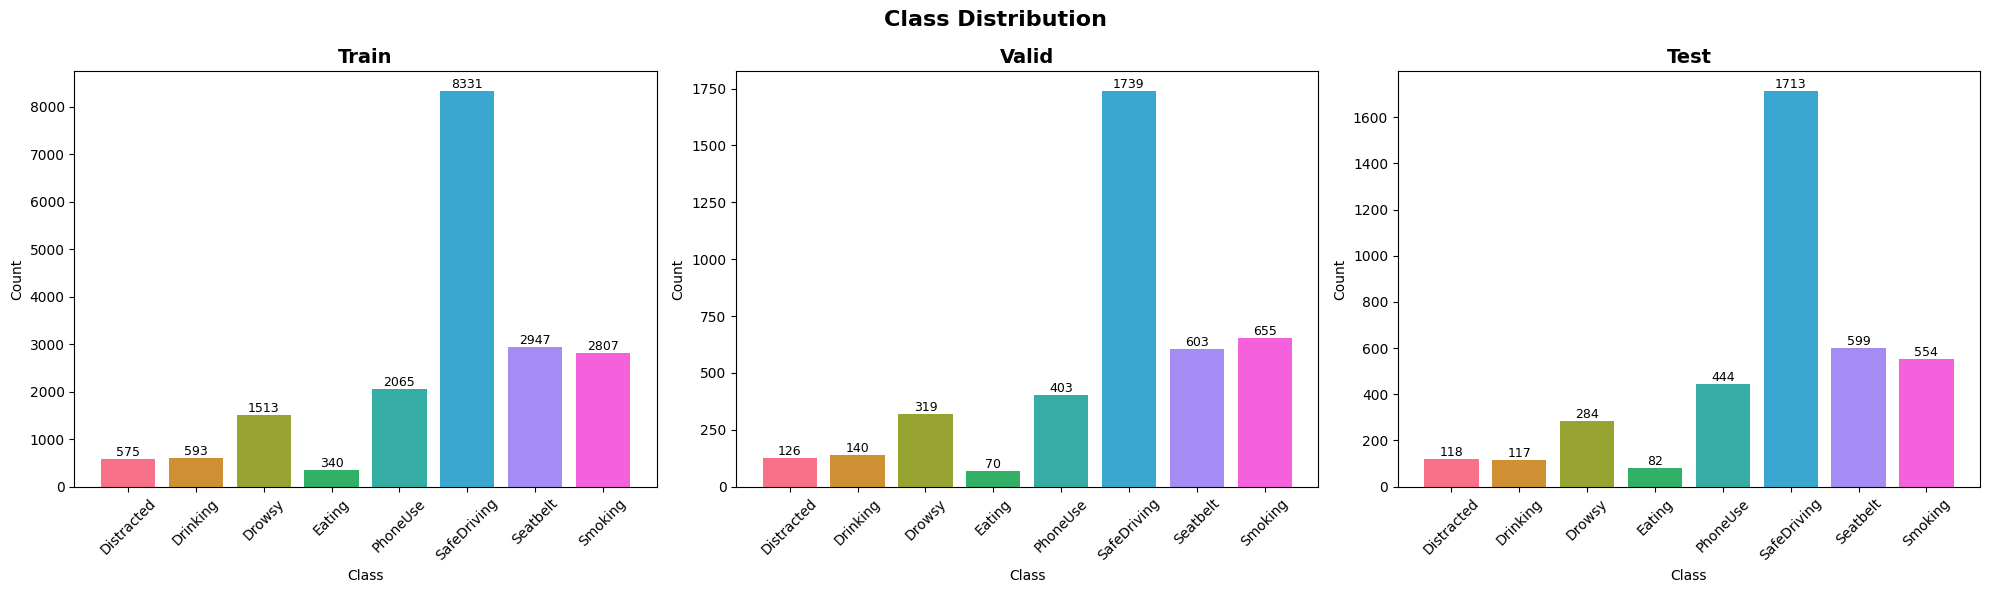

In [8]:
# Cell 8: Visualize Class Distribution
# Plot class distribution across splits
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Class Distribution', fontsize=16, fontweight='bold')

splits = [('Train', train_counts), ('Valid', val_counts), ('Test', test_counts)]

for ax, (title, counts) in zip(axes, splits):
    labels = [class_names[k] for k in sorted(counts.keys())]
    values = [counts[k] for k in sorted(counts.keys())]
    
    bars = ax.bar(labels, values, color=sns.color_palette("husl", len(labels)))
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [9]:
# Cell 9: Analyze Class Imbalance
# Calculate class imbalance ratio
total = sum(train_counts.values())
max_count = max(train_counts.values())
min_count = min(train_counts.values())

print(f"Imbalance Ratio: {max_count/min_count:.2f}:1")
print(f"Most frequent: {class_names[max(train_counts, key=train_counts.get)]} ({max_count})")
print(f"Least frequent: {class_names[min(train_counts, key=train_counts.get)]} ({min_count})")

Imbalance Ratio: 24.50:1
Most frequent: SafeDriving (8331)
Least frequent: Eating (340)


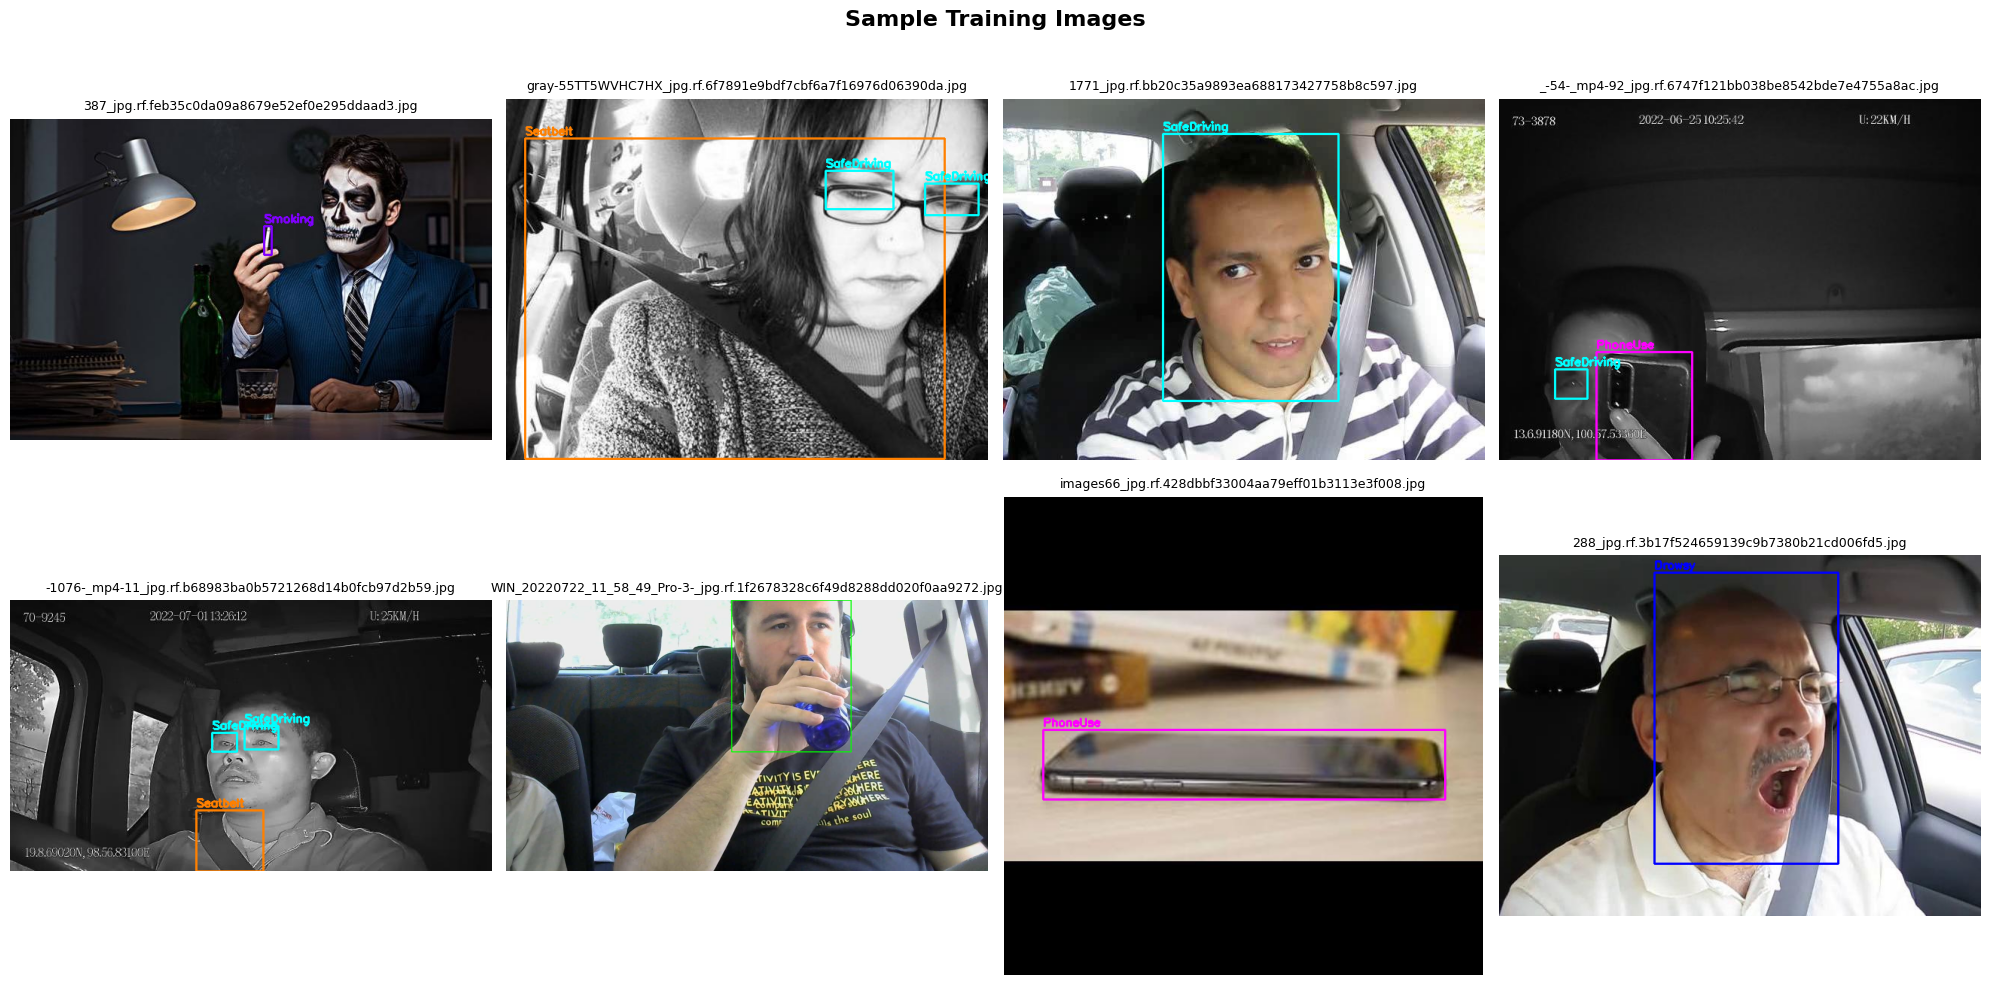

In [10]:
# Cell 10: Visualize Sample Images
# Display sample training images with annotations
def visualize_samples(image_dir, label_dir, class_names, num_samples=8):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    np.random.seed(42)
    selected = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()
    fig.suptitle('Sample Training Images', fontsize=16, fontweight='bold')
    
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), 
              (255, 0, 255), (0, 255, 255), (255, 128, 0), (128, 0, 255)]
    
    for idx, img_file in enumerate(selected):
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(label_dir, label_file)
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        cls_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:5])
                        
                        x1 = int((x_center - width/2) * w)
                        y1 = int((y_center - height/2) * h)
                        x2 = int((x_center + width/2) * w)
                        y2 = int((y_center + height/2) * h)
                        
                        color = colors[cls_id % len(colors)]
                        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                        cv2.putText(img, class_names[cls_id], (x1, y1-5),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        axes[idx].imshow(img)
        axes[idx].set_title(img_file, fontsize=9)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples(TRAIN_IMAGES, TRAIN_LABELS, class_names, num_samples=8)

## Cell 11: Training Configuration & Resume Logic

**Configuration for RTX 3050 (4GB VRAM):**
*   **Model:** YOLOv11 Nano (`yolo11n.pt`). Best for low VRAM and fast training.
*   **Batch Size:** 16. (If you get CUDA Out Of Memory, change this to 8).
*   **Epochs:** 50. (Fits approx. 2.5 hours).
*   **Imbalance Handling:** `mixup=0.1` and `cos_lr` are enabled to help with the 24.5x class imbalance.

**Auto-Resume:**
This code checks if a training run named `driver_monitor_v1` exists. 
*   If yes, it loads the `last.pt` and resumes.
*   If no, it starts a fresh training.

In [11]:
# Define Project Constants
PROJECT_NAME = "driver_monitor_sys"
RUN_NAME = "yolo11n_imbalance_fix"
CHECKPOINT_DIR = os.path.join(PROJECT_NAME, RUN_NAME, "weights")
LAST_WEIGHT = os.path.join(CHECKPOINT_DIR, "last.pt")

# Training Arguments optimized for RTX 3050 4GB
train_args = {
    "data": DATA_YAML,
    "epochs": 50,           # fits in ~2-3 hours
    "imgsz": 640,           # Standard resolution
    "batch": 16,            # 16 fits 4GB VRAM. If Crash -> use 8
    "device": 0,            # GPU 0
    "workers": 4,
    "project": PROJECT_NAME,
    "name": RUN_NAME,
    "exist_ok": True,
    "patience": 10,         # Early stopping
    "cos_lr": True,         # Helps convergence
    "optimizer": "AdamW",
    "verbose": True,
    
    # --- Imbalance Augmentation Strategies ---
    "mosaic": 1.0,          # Strong mosaic (helps small objects)
    "mixup": 0.1,           # Blends images to help minority classes
    "degrees": 10.0,        # Slight rotation
}

print("Checking for existing checkpoints...")

if os.path.exists(LAST_WEIGHT):
    print(f"✅ Previous checkpoint found at: {LAST_WEIGHT}")
    print("Resuming training...")
    
    # Resume Logic
    model = YOLO(LAST_WEIGHT)
    model.train(resume=True)

else:
    print("❌ No checkpoint found. Starting fresh training with YOLOv11 Nano...")
    
    # Start Fresh
    model = YOLO("yolo11n.pt")  # Using v11 nano for speed/accuracy balance
    model.train(**train_args)

Checking for existing checkpoints...
❌ No checkpoint found. Starting fresh training with YOLOv11 Nano...
New https://pypi.org/project/ultralytics/8.3.252 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.251  Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=Driver-Monitoring-system-1/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=30

## Cell 12: Validate Model
Once training finishes, run this to see the breakdown of accuracy per class (mAP). Look specifically at 'Eating' and 'Distracted' scores.

In [12]:
# Load the best model from the training run
best_weight = os.path.join(PROJECT_NAME, RUN_NAME, "weights", "best.pt")

if os.path.exists(best_weight):
    print(f"Loading best model: {best_weight}")
    best_model = YOLO(best_weight)
    
    # Validate on test set
    metrics = best_model.val(split='test')
    
    print(f"\nmap50: {metrics.box.map50}")
    print(f"map50-95: {metrics.box.map}")
else:
    print("Training not finished or best.pt not found.")

Loading best model: driver_monitor_sys\yolo11n_imbalance_fix\weights\best.pt
Ultralytics 8.3.251  Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11n summary (fused): 100 layers, 2,583,712 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.20.1 ms, read: 5.35.8 MB/s, size: 61.6 KB)
val: Scanning C:\Users\jadha\Desktop\Driver-Monitoring-System\Driver-Monitoring-system-1\test\labels... 1952 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1952/1952 143.1it/s 13.6s0.2s
val: New cache created: C:\Users\jadha\Desktop\Driver-Monitoring-System\Driver-Monitoring-system-1\test\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 122/122 4.7it/s 26.1s0.2s
                   all       1952       3911      0.891      0.845      0.913      0.664
            Distracted        116        118      0.939       0.91      0.978      0.835
              Drinking        116    